In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mxnet as mx
print("mxnet version: ", mx.__version__)
from mxnet import autograd, init, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn 
import numpy as np
import pandas as pd

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
ROOT_DIR = "../input/house_predict"
print(os.listdir(ROOT_DIR))

# Any results you write to the current directory are saved as output.

/Users/i058959/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


mxnet version:  1.2.1
['test.csv.gz', '.DS_Store', 'train.csv.gz']


In [2]:
if os.path.exists('%s/train.csv' % (ROOT_DIR)):
    # in case only csv here
    train_data = pd.read_csv('%s/train.csv' % (ROOT_DIR))
    test_data = pd.read_csv('%s/test.csv' % (ROOT_DIR))
else:
    # in case only csv.gz here
    train_data = pd.read_csv('%s/train.csv.gz' % (ROOT_DIR), compression='gzip')
    test_data = pd.read_csv('%s/test.csv.gz' % (ROOT_DIR), compression='gzip')

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
# id is just a identifier, so generate features of data
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
# Normalization for non-object features - Numeric featue normalizatoin
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(all_features.mean())

In [8]:
all_features.shape

(2919, 79)

In [9]:
# Convert discrete value to indictor feature
# dummy_na=True 将 NaN 也当做合法的特征值并为其创建指示特征。 
all_features = pd.get_dummies(all_features, dummy_na=True) 
all_features.shape

(2919, 331)

In [10]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [11]:
loss = gloss.L2Loss()
def get_net():
    """
    define network with house price for linear regression model.
    """
    net = nn.Sequential() 
    net.add(nn.Dense(2048, activation='relu'), nn.Dense(1))
#     net.add(nn.Dense(640, activation='relu'), nn.Dense(1))
# Bug: not good effect
#     net.add(nn.Dense(512), nn.LeakyReLU(0.1), nn.Dense(1))
#     net.add(nn.Dense(512, activation='relu'), nn.Dense(1))
#     net.add(nn.Dense(1))
    net.initialize() 
    return net

In [12]:
def log_rmse(net, train_features, train_labels): 
    # 将小于 1 的预测值设成 1，使得取对数时数值更稳定。
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), train_labels.log()).mean()) 
    return rmse.asscalar()

In [13]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True) # 这里使用了 Adam 优化算法。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay}) 
    for epoch in range(num_epochs):
        for X, y in train_iter: 
            with autograd.record(): 
                l = loss(net(X), y)
            l.backward()
        trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels)) 
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) 
    return train_ls, test_ls

In [14]:
def get_k_fold_data(k, i, X, y): 
    assert k > 1
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None 
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) 
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_test, y_test = X_part, y_part 
        elif X_train is None:
            X_train, y_train = X_part, y_part 
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0) 
    return X_train, y_train, X_test, y_test

In [15]:
from IPython import display
from matplotlib import pyplot as plt

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    Plot x and log(y).
    Access link - https://github.com/mli/gluon-tutorials-zh/tree/master/gluonbook/utils.py
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

def set_figsize(figsize=(3.5, 2.5)):
    """
    Set matplotlib figure size.
    Access link - https://github.com/mli/gluon-tutorials-zh/tree/master/gluonbook/utils.py
    """
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def use_svg_display():
    """
    Use svg format to display plot in jupyter.
    Access link - https://github.com/mli/gluon-tutorials-zh/tree/master/gluonbook/utils.py
    """
    display.set_matplotlib_formats('svg')

In [16]:
def k_fold(k, X_train, y_train, num_epochs,learning_rate, weight_decay, batch_size): 
    train_l_sum, test_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, test_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        test_l_sum += test_ls[-1] 
        if i == 0:
            semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse', range(1, num_epochs+1), test_ls, ['train', 'test'])
        print('fold %d, train rmse: %f, test rmse: %f' % ( i, train_ls[-1], test_ls[-1]))
    return train_l_sum / k, test_l_sum / k

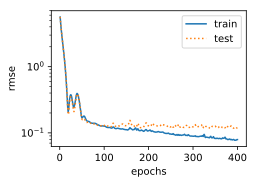

fold 0, train rmse: 0.079191, test rmse: 0.118921
fold 1, train rmse: 0.076152, test rmse: 0.139153
fold 2, train rmse: 0.069688, test rmse: 0.128331
fold 3, train rmse: 0.071533, test rmse: 0.114575
fold 4, train rmse: 0.073830, test rmse: 0.146168
5-fold validation: avg train rmse: 0.074079, avg test rmse: 0.129430


In [17]:
k = 5
num_epochs = 400
verbose_epoch = num_epochs - 2
lr = 0.1
weight_decay = 10
batch_size = 1024
train_l, test_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg test rmse: %f' % (k, train_l, test_l))

In [18]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

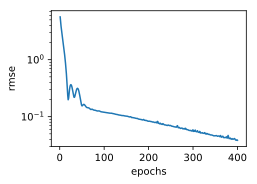

train rmse 0.038590


In [19]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

### Competition Result

#### 1. House Price
URL - https://www.kaggle.com/c/house-prices-advanced-regression-techniques

#### 2. Parameter initializer
Default initializer - [Block](https://github.com/apache/incubator-mxnet/blob/master/python/mxnet/gluon/block.py#L486) via (Line 486 of ctor of nn.Block via init=initializer.Uniform())

#### 3. Result for current setting
| Version | Submission Time | Author | Script | Evaluation Point |
|:-------------:|:--------------:|:---------------:|:------------------------:|:-------:|
| Version 10/18 | 2018-08-31 18:30 |  Orlando Ding   | ["housePrice" 5428530](https://www.kaggle.com/orlando23/houseprice?scriptVersionId=5428530) | 0.12092 |
| Version 18/18 | 2018-09-01 11:30 |  Orlando Ding   | ["housePrice" 5441110](https://www.kaggle.com/orlando23/houseprice?scriptVersionId=5441110) | 0.12404 |